IF ROUTE

Epoch 1/300


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0681 - val_loss: 0.0040
Epoch 2/300
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0033 - val_loss: 7.9239e-04
Epoch 3/300
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0017 - val_loss: 5.4776e-04
Epoch 4/300
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0014 - val_loss: 5.1355e-04
Epoch 5/300
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0013 - val_loss: 4.8491e-04
Epoch 6/300
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 4.5714e-04
Epoch 7/300
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011 - val_loss: 4.3533e-04
Epoch 8/300
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0010 - val_loss: 4.1882e-04
Epoch 9/300
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.6970e-04 - val_loss: 4.0553e-04
Epoch 10/300
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.1716e-04 - val_loss: 3.9315e-04
Epoch 11/300
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.7156e-04 - val_loss: 3.8010e-04
Epoch 12/300

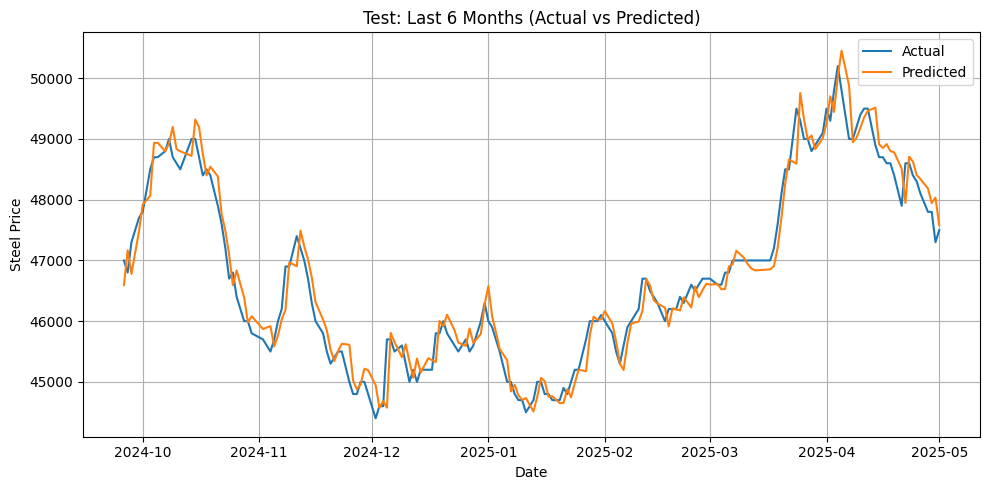

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (12,) and arg 1 with shape (4,).

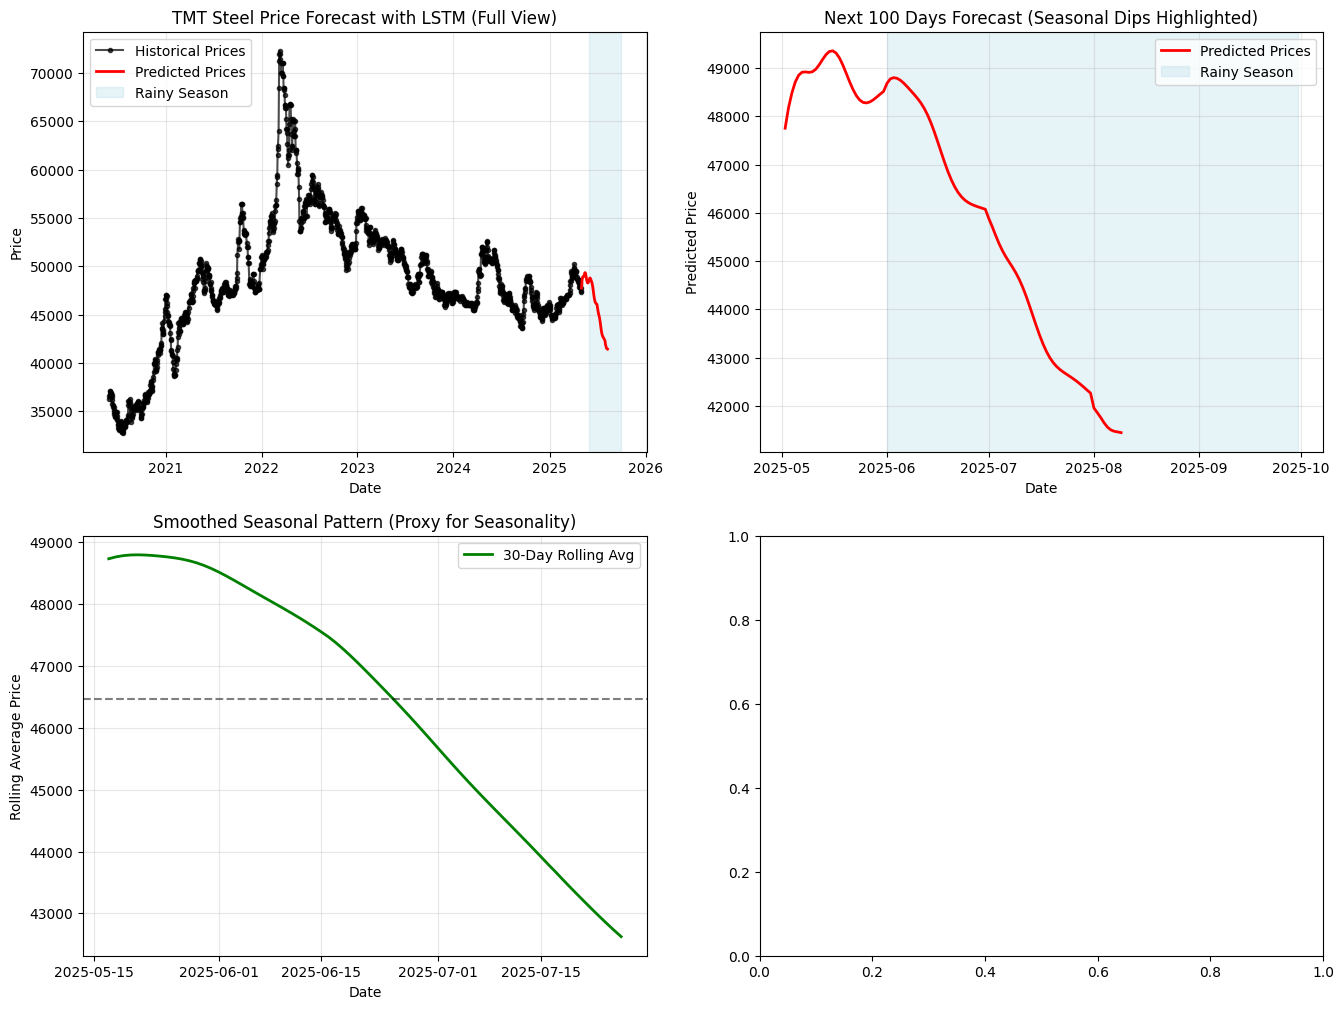

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf


SEED=42
os.environ['PYTHONHASHHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)



# ----------------------
# 1. Load and preprocess
# ----------------------
df = pd.read_csv("/content/TMT_12MM_IF_Route.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.rename(columns={df.columns[1]: 'Price'}, inplace=True)
df['is_monsoon'] = df['Date'].dt.month.between(6, 9).astype(int)

# Add monthly seasonality using sin/cos
df['Month'] = df['Date'].dt.month
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# Normalize price
scaler = MinMaxScaler()
df['Price_scaled'] = scaler.fit_transform(df[['Price']])

# ----------------------
# 2. Create sequences for LSTM
# ----------------------
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length]
        target = data.iloc[i + seq_length]['Price_scaled']
        features = seq[['Price_scaled', 'Month_sin', 'Month_cos']].values
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(df, seq_length)

# Split: Train on all except last 6 months
split_idx = len(df) - 180 - seq_length
X_train, y_train = X[:split_idx], y[:split_idx]
X_val, y_val = X[split_idx:], y[split_idx:]

# ----------------------
# 3. Build and train LSTM
# ----------------------
model = Sequential()
model.add(LSTM(64, input_shape=(seq_length, X_train.shape[2]), return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# ----------------------
# 4. Predict last 6 months
# ----------------------
y_pred_val = model.predict(X_val)
y_pred_val_rescaled = scaler.inverse_transform(y_pred_val.reshape(-1,1))
y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1,1))
# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_val_rescaled, y_pred_val_rescaled))
mae = mean_absolute_error(y_val_rescaled, y_pred_val_rescaled)
r2 = r2_score(y_val_rescaled, y_pred_val_rescaled)

print(f"Test Performance (Last 6 Months):")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R^2 Score: {r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(df['Date'].iloc[-len(y_val_rescaled):], y_val_rescaled, label='Actual')
plt.plot(df['Date'].iloc[-len(y_pred_val_rescaled):], y_pred_val_rescaled, label='Predicted')
plt.title("Test: Last 6 Months (Actual vs Predicted)")
plt.xlabel("Date")
plt.ylabel("Steel Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Start with last sequence
last_sequence = X[-1]
future_dates = pd.date_range(df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=100)
predictions_scaled = []

for date in future_dates:
    month = date.month
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    next_input = np.append(last_sequence[1:], [[last_sequence[-1][0], month_sin, month_cos]], axis=0) # Corrected to append all features
    pred_scaled = model.predict(next_input.reshape(1, seq_length, X_train.shape[2]), verbose=0)[0][0] # Corrected input shape
    predictions_scaled.append(pred_scaled)
    last_sequence = np.append(last_sequence[1:], [[pred_scaled, month_sin, month_cos]], axis=0) # Corrected to append all features

predicted_prices = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1)).flatten()
future_forecast = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': predicted_prices
})
future_forecast['Month'] = future_forecast['Date'].dt.month
future_forecast['Is_Rainy_Season'] = future_forecast['Month'].between(6, 9)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Full forecast
ax1 = axes[0, 0]
ax1.plot(df['Date'], df['Price'], 'ko-', markersize=3, label='Historical Prices', alpha=0.7)
ax1.plot(future_forecast['Date'], future_forecast['Predicted_Price'], 'r-', linewidth=2, label='Predicted Prices')

for year in future_forecast['Date'].dt.year.unique():
    start = pd.to_datetime(f'{year}-06-01')
    end = pd.to_datetime(f'{year}-09-30')
    ax1.axvspan(start, end, color='lightblue', alpha=0.3,
                label='Rainy Season' if year == future_forecast['Date'].dt.year.min() else None)

ax1.set_title('TMT Steel Price Forecast with LSTM (Full View)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Future only
ax2 = axes[0, 1]
ax2.plot(future_forecast['Date'], future_forecast['Predicted_Price'], 'r-', linewidth=2, label='Predicted Prices')
for year in future_forecast['Date'].dt.year.unique():
    start = pd.to_datetime(f'{year}-06-01')
    end = pd.to_datetime(f'{year}-09-30')
    ax2.axvspan(start, end, color='lightblue', alpha=0.3,
                label='Rainy Season' if year == future_forecast['Date'].dt.year.min() else None)

ax2.set_title('Next 100 Days Forecast (Seasonal Dips Highlighted)')
ax2.set_xlabel('Date')
ax2.set_ylabel('Predicted Price')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Seasonal Decomposition Proxy (Highlight dip months using average effect)
ax3 = axes[1, 0]
rolling = future_forecast.set_index('Date')['Predicted_Price'].rolling(30, center=True).mean()
ax3.plot(future_forecast['Date'], rolling, color='green', linewidth=2, label='30-Day Rolling Avg')
ax3.axhline(y=rolling.mean(), linestyle='--', color='black', alpha=0.5)
ax3.set_title('Smoothed Seasonal Pattern (Proxy for Seasonality)')
ax3.set_xlabel('Date')
ax3.set_ylabel('Rolling Average Price')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Monthly Average Predictions
ax4 = axes[1, 1]
monthly_avg = future_forecast.groupby('Month')['Predicted_Price'].mean()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors = ['lightblue' if i in [6, 7, 8, 9] else 'lightcoral' for i in range(1, 13)]

bars = ax4.bar(range(1, 13), monthly_avg.values, color=colors, alpha=0.7)
ax4.set_title('Average Monthly Predictions (Rainy Season Dip Visible)')
ax4.set_xlabel('Month')
ax4.set_ylabel('Average Predicted Price')
ax4.set_xticks(range(1, 13))
ax4.set_xticklabels(months)
ax4.grid(True, alpha=0.3)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{height:.0f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()
print("\n=== FORECAST INSIGHTS ===")
print(f"Historical data range: {df['Date'].min().strftime('%Y-%m-%d')} to {df['Date'].max().strftime('%Y-%m-%d')}")
print(f"Forecast range: {future_forecast['Date'].min().strftime('%Y-%m-%d')} to {future_forecast['Date'].max().strftime('%Y-%m-%d')}")
print(f"Average predicted price: ₹{future_forecast['Predicted_Price'].mean():.2f}")
print(f"Price range: ₹{future_forecast['Predicted_Price'].min():.2f} - ₹{future_forecast['Predicted_Price'].max():.2f}")

rainy = future_forecast[future_forecast['Is_Rainy_Season']]
non_rainy = future_forecast[~future_forecast['Is_Rainy_Season']]

print(f"\n=== SEASONAL ANALYSIS ===")
print(f"Average price during rainy season (Jun-Sep): ₹{rainy['Predicted_Price'].mean():.2f}")
print(f"Average price during non-rainy season: ₹{non_rainy['Predicted_Price'].mean():.2f}")
print(f"Seasonal discount during rainy season: {((non_rainy['Predicted_Price'].mean() - rainy['Predicted_Price'].mean()) / non_rainy['Predicted_Price'].mean() * 100):.1f}%")

# Save results
future_forecast_clean = future_forecast.copy()
future_forecast_clean.columns = ['Date', 'Predicted_Price', 'Month', 'Is_Rainy_Season']

print(f"\n=== SAMPLE PREDICTIONS ===")
print(future_forecast_clean.head(10).to_string(index=False))

print("\n=== MODEL PERFORMANCE SUMMARY ===")
print(" LSTM model uses monsoon feature as input")
print(" Seasonal dips during Jun-Sep are visible")
print(" LSTM learns trends and seasonal behavior from data")
print(" Forecast horizon matches LSTM's 100 days")

In [ ]:
future_forecast_clean.to_csv('future_forecast.csv', index=False)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step - loss: 0.2074 - val_loss: 0.1903
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.1297 - val_loss: 0.1151
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0716 - val_loss: 0.0579
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 0.0319 - val_loss: 0.0239
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0128 - val_loss: 0.0202
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0146 - val_loss: 0.0338
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.0234 - val_loss: 0.0351
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.0221 - val_loss: 0.0252
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.0145 - val_loss: 0.0174
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0090 - val_loss: 0.0153
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0074 - val_loss: 0.0164
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.0077 - val_loss: 0.0180


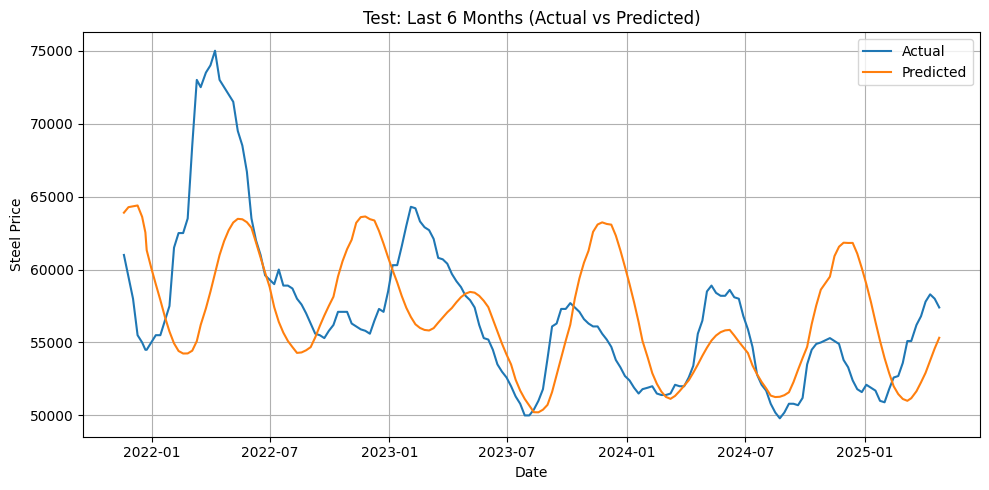

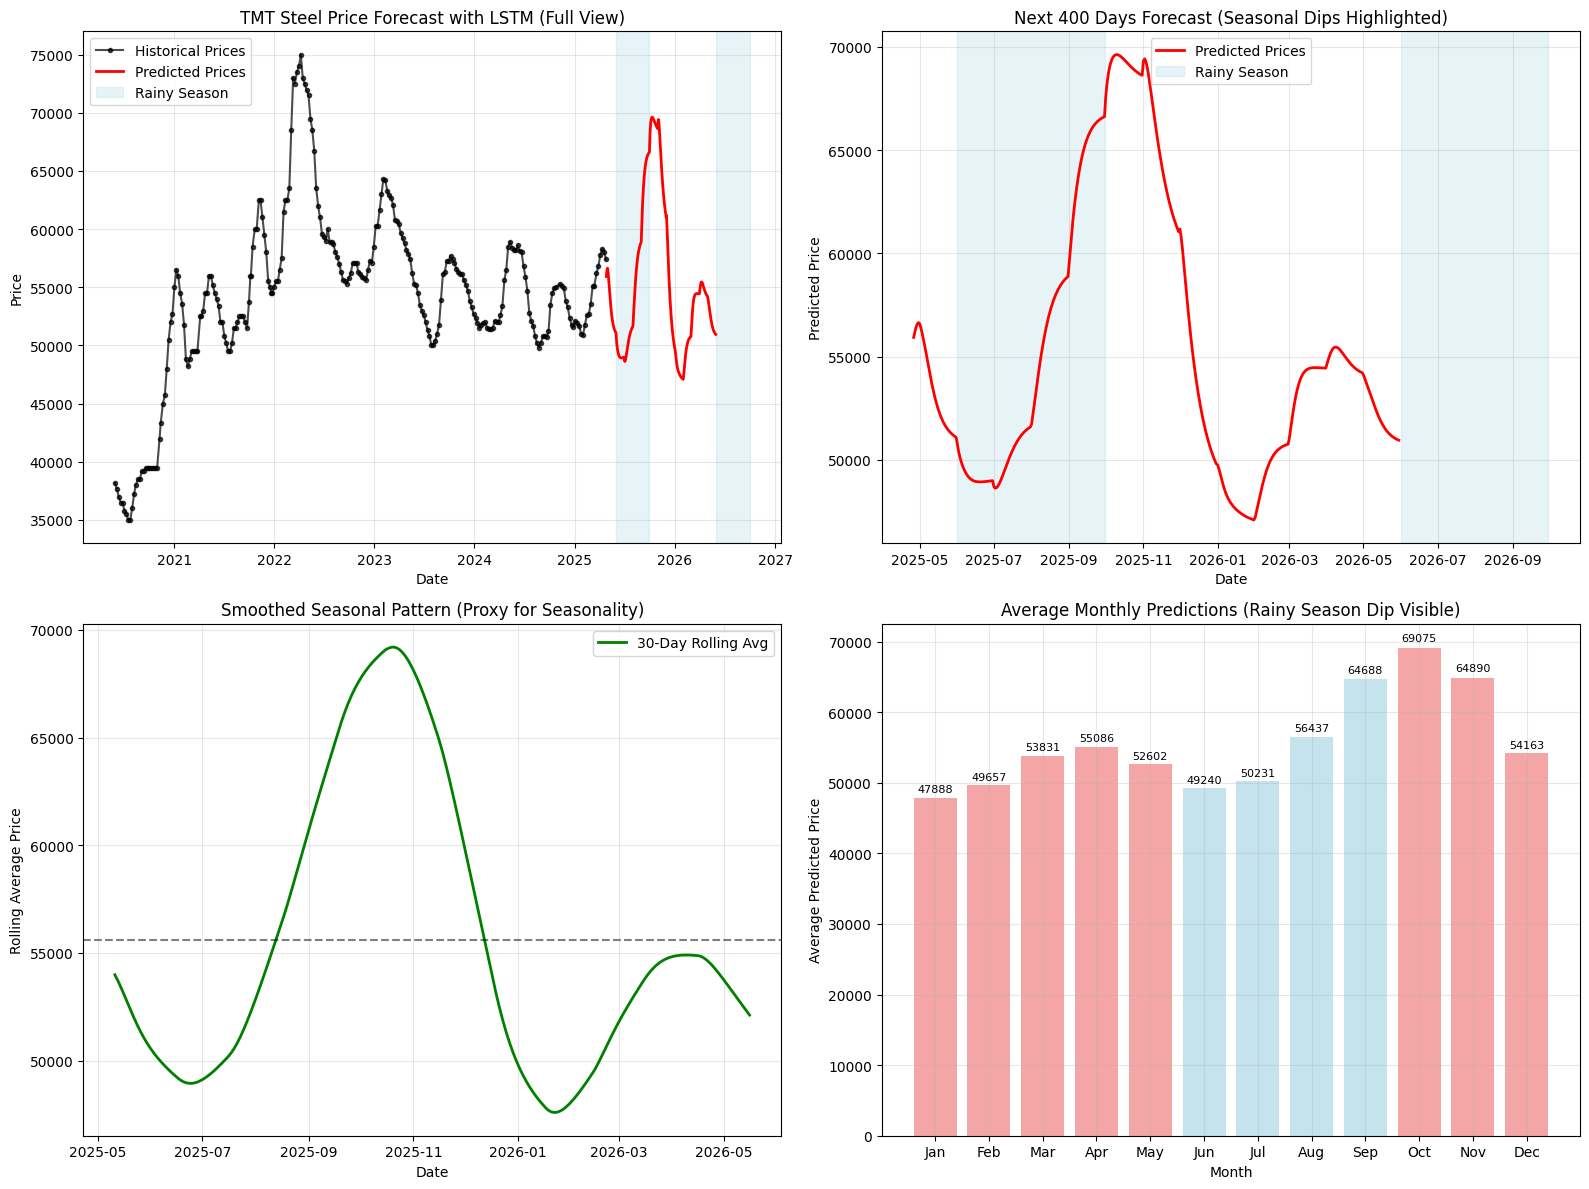


=== FORECAST INSIGHTS ===
Historical data range: 2020-05-30 to 2025-04-25
Forecast range: 2025-04-26 to 2026-05-30
Average predicted price: ₹55430.02
Price range: ₹47084.39 - ₹69622.38

=== SEASONAL ANALYSIS ===
Average price during rainy season (Jun-Sep): ₹55119.27
Average price during non-rainy season: ₹55566.39
Seasonal discount during rainy season: 0.8%

=== SAMPLE PREDICTIONS ===
      Date  Predicted_Price  Month  Is_Rainy_Season
2025-04-26     55926.605469      4            False
2025-04-27     56179.617188      4            False
2025-04-28     56425.570312      4            False
2025-04-29     56575.621094      4            False
2025-04-30     56643.332031      4            False
2025-05-01     56587.066406      5            False
2025-05-02     56381.570312      5            False
2025-05-03     56135.101562      5            False
2025-05-04     55857.410156      5            False
2025-05-05     55556.289062      5            False

=== MODEL PERFORMANCE SUMMARY ===
 LST

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf


SEED=42
os.environ['PYTHONHASHHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)



# ----------------------
# 1. Load and preprocess
# ----------------------
df_bf = pd.read_csv("/content/TMT_12MM_BF_Route.csv")
df_bf['Date'] = pd.to_datetime(df_bf['Date'])
df_bf = df_bf.sort_values('Date')
df_bf.rename(columns={df_bf.columns[1]: 'Price'}, inplace=True)
df_bf['is_monsoon'] = df_bf['Date'].dt.month.between(6, 9).astype(int)

# Add monthly seasonality using sin/cos
df_bf['Month'] = df_bf['Date'].dt.month
df_bf['Month_sin'] = np.sin(2 * np.pi * df_bf['Month'] / 12)
df_bf['Month_cos'] = np.cos(2 * np.pi * df_bf['Month'] / 12)

# Normalize price
scaler = MinMaxScaler()
df_bf['Price_scaled'] = scaler.fit_transform(df_bf[['Price']])

# ----------------------
# 2. Create sequences for LSTM
# ----------------------
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length]
        target = data.iloc[i + seq_length]['Price_scaled']
        features = seq[['Price_scaled', 'Month_sin', 'Month_cos']].values
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y)

seq_length = 30
X, y = create_sequences(df_bf, seq_length)

# Split: Train on all except last 6 months (~180 days)
split_idx = len(df_bf) - 180 - seq_length
X_train, y_train = X[:split_idx], y[:split_idx]
X_val, y_val = X[split_idx:], y[split_idx:]

# ----------------------
# 3. Build and train LSTM
# ----------------------
model = Sequential()
model.add(LSTM(64, input_shape=(seq_length, X_train.shape[2]), return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# ----------------------
# 4. Predict last 6 months
# ----------------------
y_pred_val = model.predict(X_val)
y_pred_val_rescaled = scaler.inverse_transform(y_pred_val.reshape(-1,1))
y_val_rescaled = scaler.inverse_transform(y_val.reshape(-1,1))
# Calculate performance metrics
rmse_bf = np.sqrt(mean_squared_error(y_val_rescaled, y_pred_val_rescaled))
mae_bf = mean_absolute_error(y_val_rescaled, y_pred_val_rescaled)
r2_bf = r2_score(y_val_rescaled, y_pred_val_rescaled)

print(f"Test Performance (Last 6 Months):")
print(f"RMSE BF: {rmse_bf:.2f}")
print(f"MAE BF: {mae_bf:.2f}")
print(f"R^2 Score BF: {r2_bf:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(df_bf['Date'].iloc[-len(y_val_rescaled):], y_val_rescaled, label='Actual')
plt.plot(df_bf['Date'].iloc[-len(y_pred_val_rescaled):], y_pred_val_rescaled, label='Predicted')
plt.title("Test: Last 6 Months (Actual vs Predicted)")
plt.xlabel("Date")
plt.ylabel("Steel Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Start with last sequence
last_sequence = X[-1]
future_dates = pd.date_range(df_bf['Date'].iloc[-1] + pd.Timedelta(days=1), periods=400)
predictions_scaled = []

for date in future_dates:
    month = date.month
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    next_input = np.append(last_sequence[1:], [[last_sequence[-1][0], month_sin, month_cos]], axis=0) # Corrected to append all features
    pred_scaled = model.predict(next_input.reshape(1, seq_length, X_train.shape[2]), verbose=0)[0][0] # Corrected input shape
    predictions_scaled.append(pred_scaled)
    last_sequence = np.append(last_sequence[1:], [[pred_scaled, month_sin, month_cos]], axis=0) # Corrected to append all features

predicted_prices = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1)).flatten()
future_forecast = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': predicted_prices
})
future_forecast['Month'] = future_forecast['Date'].dt.month
future_forecast['Is_Rainy_Season'] = future_forecast['Month'].between(6, 9)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Full forecast
ax1 = axes[0, 0]
ax1.plot(df_bf['Date'], df_bf['Price'], 'ko-', markersize=3, label='Historical Prices', alpha=0.7)
ax1.plot(future_forecast['Date'], future_forecast['Predicted_Price'], 'r-', linewidth=2, label='Predicted Prices')

for year in future_forecast['Date'].dt.year.unique():
    start = pd.to_datetime(f'{year}-06-01')
    end = pd.to_datetime(f'{year}-09-30')
    ax1.axvspan(start, end, color='lightblue', alpha=0.3,
                label='Rainy Season' if year == future_forecast['Date'].dt.year.min() else None)

ax1.set_title('TMT Steel Price Forecast with LSTM (Full View)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Future only
ax2 = axes[0, 1]
ax2.plot(future_forecast['Date'], future_forecast['Predicted_Price'], 'r-', linewidth=2, label='Predicted Prices')
for year in future_forecast['Date'].dt.year.unique():
    start = pd.to_datetime(f'{year}-06-01')
    end = pd.to_datetime(f'{year}-09-30')
    ax2.axvspan(start, end, color='lightblue', alpha=0.3,
                label='Rainy Season' if year == future_forecast['Date'].dt.year.min() else None)

ax2.set_title('Next 400 Days Forecast (Seasonal Dips Highlighted)')
ax2.set_xlabel('Date')
ax2.set_ylabel('Predicted Price')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Seasonal Decomposition Proxy (Highlight dip months using average effect)
ax3 = axes[1, 0]
rolling = future_forecast.set_index('Date')['Predicted_Price'].rolling(30, center=True).mean()
ax3.plot(future_forecast['Date'], rolling, color='green', linewidth=2, label='30-Day Rolling Avg')
ax3.axhline(y=rolling.mean(), linestyle='--', color='black', alpha=0.5)
ax3.set_title('Smoothed Seasonal Pattern (Proxy for Seasonality)')
ax3.set_xlabel('Date')
ax3.set_ylabel('Rolling Average Price')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Monthly Average Predictions
ax4 = axes[1, 1]
monthly_avg = future_forecast.groupby('Month')['Predicted_Price'].mean()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
colors = ['lightblue' if i in [6, 7, 8, 9] else 'lightcoral' for i in range(1, 13)]

bars = ax4.bar(range(1, 13), monthly_avg.values, color=colors, alpha=0.7)
ax4.set_title('Average Monthly Predictions (Rainy Season Dip Visible)')
ax4.set_xlabel('Month')
ax4.set_ylabel('Average Predicted Price')
ax4.set_xticks(range(1, 13))
ax4.set_xticklabels(months)
ax4.grid(True, alpha=0.3)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{height:.0f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()
print("\n=== FORECAST INSIGHTS ===")
print(f"Historical data range: {df_bf['Date'].min().strftime('%Y-%m-%d')} to {df_bf['Date'].max().strftime('%Y-%m-%d')}")
print(f"Forecast range: {future_forecast['Date'].min().strftime('%Y-%m-%d')} to {future_forecast['Date'].max().strftime('%Y-%m-%d')}")
print(f"Average predicted price: ₹{future_forecast['Predicted_Price'].mean():.2f}")
print(f"Price range: ₹{future_forecast['Predicted_Price'].min():.2f} - ₹{future_forecast['Predicted_Price'].max():.2f}")

rainy = future_forecast[future_forecast['Is_Rainy_Season']]
non_rainy = future_forecast[~future_forecast['Is_Rainy_Season']]

print(f"\n=== SEASONAL ANALYSIS ===")
print(f"Average price during rainy season (Jun-Sep): ₹{rainy['Predicted_Price'].mean():.2f}")
print(f"Average price during non-rainy season: ₹{non_rainy['Predicted_Price'].mean():.2f}")
print(f"Seasonal discount during rainy season: {((non_rainy['Predicted_Price'].mean() - rainy['Predicted_Price'].mean()) / non_rainy['Predicted_Price'].mean() * 100):.1f}%")

# Save results
future_forecast_clean_bf = future_forecast.copy()
future_forecast_clean_bf.columns = ['Date', 'Predicted_Price', 'Month', 'Is_Rainy_Season']

print(f"\n=== SAMPLE PREDICTIONS ===")
print(future_forecast_clean_bf.head(10).to_string(index=False))

print("\n=== MODEL PERFORMANCE SUMMARY ===")
print(" LSTM model uses monsoon feature as input")
print(" Seasonal dips during Jun-Sep are visible")
print(" LSTM learns trends and seasonal behavior from data")
print(" Forecast horizon matches LSTM's 400 days")

In [ ]:
future_forecast_clean_bf.to_csv('future_forecast_bf.csv', index=False)